In [1]:
import pyspark as ps
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta
import scipy.stats as stats

In [27]:
df = pd.read_csv('data/cleaned_data.csv')

In [28]:
df

,Unnamed: 0,Name,Country,Gender,Division,Swim,Bike,Run,Overall,Division Rank,Gender Rank,Overall Rank,T1,T2
0,0,"Frodeno, Jan",DEU,Male,MPRO,47.516667,256.033333,162.716667,471.216667,1,1,1,1.966667,2.983333
1,1,"O'donnell, Tim",USA,Male,MPRO,47.633333,258.183333,169.750000,479.683333,2,2,2,2.016667,2.100000
2,2,"Kienle, Sebastian",DEU,Male,MPRO,52.283333,255.066667,169.933333,482.066667,3,3,3,2.200000,2.583333
3,3,"Hoffman, Ben",USA,Male,MPRO,51.016667,264.016667,163.133333,482.866667,4,4,4,2.416667,2.283333
4,4,"Wurf, Cameron",AUS,Male,MPRO,52.416667,254.733333,175.050000,486.683333,5,5,5,2.116667,2.366667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2253,"Beavers, Cathy",USA,Female,F65-69,105.500000,505.016667,378.866667,1010.050000,26,609,2262,10.416667,10.250000
2252,2254,"Whitehouse, Paul",USA,Male,M70-74,126.016667,471.333333,389.566667,1010.066667,28,1654,2263,11.816667,11.333333
2253,2255,"Svoboda-vasquez, Hanna",DEU,Female,F50-54,89.550000,496.450000,407.700000,1011.050000,66,610,2264,9.783333,7.566667
2254,2256,"Piasentini, Edgardo",ARG,Male,M65-69,102.450000,462.150000,433.816667,1013.350000,50,1655,2265,6.283333,8.650000


# Separating DF to Pros and Amateurs by Gender

In [30]:
male_results = df[df['Gender'] == 'Male']
male_pro = male_results[male_results['Division'] == 'MPRO']
male_agegroups = male_results[male_results['Division'] != 'MPRO']

In [31]:
fem_results = df[df['Gender'] == 'Female']
fem_pro = fem_results[fem_results['Division'] == 'FPRO']
fem_agegroups = fem_results[fem_results['Division'] != 'FPRO']

# Plotting scatters of pro event times by gender

In [37]:
def plot_genders_rank(sport, df1=fem_pro, df2=male_pro):
    xf = df1['Division Rank']
    yf = df1[sport]
    xm = df2['Division Rank']
    ym = df2[sport]

    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(xf, yf, c='pink')
    ax.scatter(xm, ym)

    ax.set_title(f'{sport} Times by Ranking')
    ax.set_xlabel('Division Rank')
    ax.set_ylabel(f'{sport} Time (minutes)')

    ax.axvline(1, c='pink', linestyle="--")
    ax.axvline(xf.max(), c='pink', linestyle="--")
    ax.axvline(1, c='grey', linestyle="--")
    ax.axvline(xm.max(), c='grey', linestyle="--")
    return fig, ax

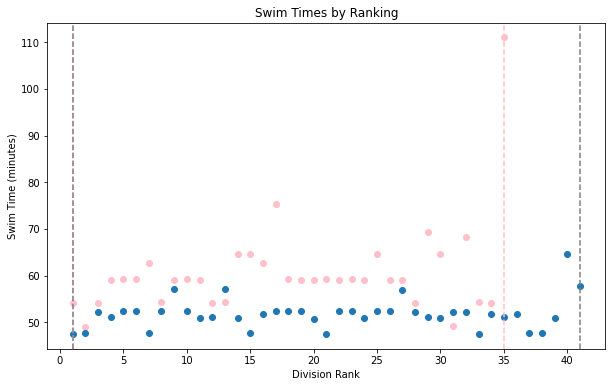

In [47]:
plot_genders_rank('Swim')

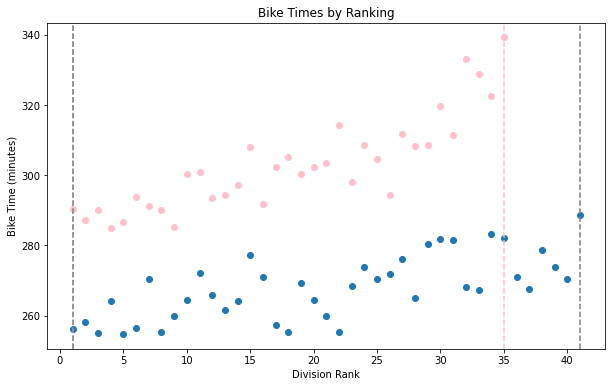

In [48]:
plot_genders_rank('Bike')

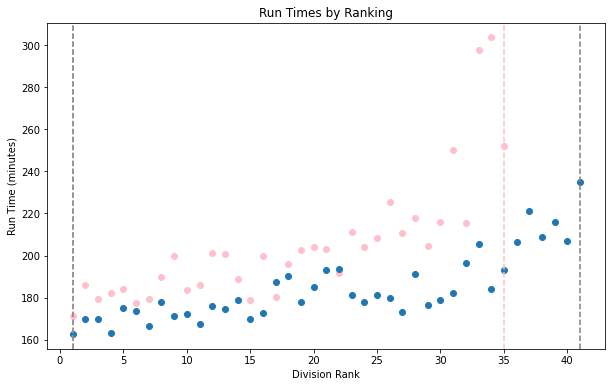

In [52]:
plot_genders_rank('Run')

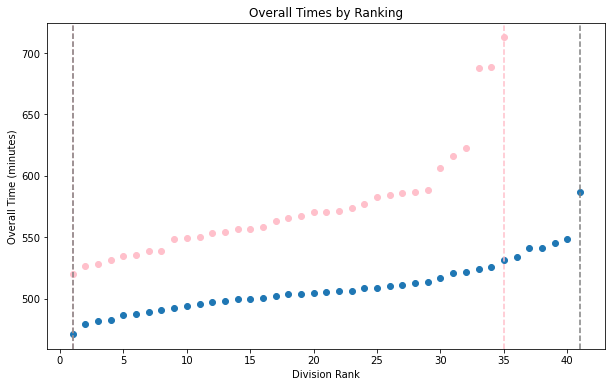

In [51]:
plot_genders_rank('Overall')

# Plotting scatters of amateur event times by gender

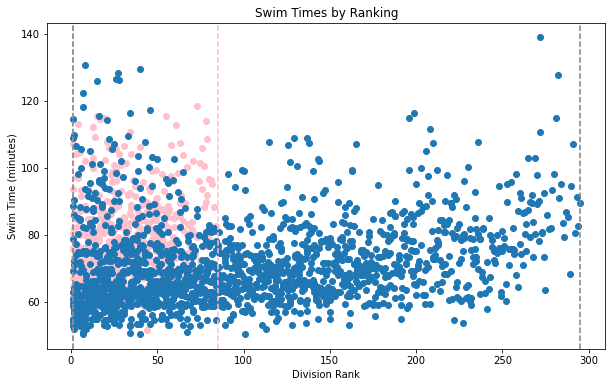

In [53]:
plot_genders_rank('Swim', df1=fem_agegroups, df2=male_agegroups)

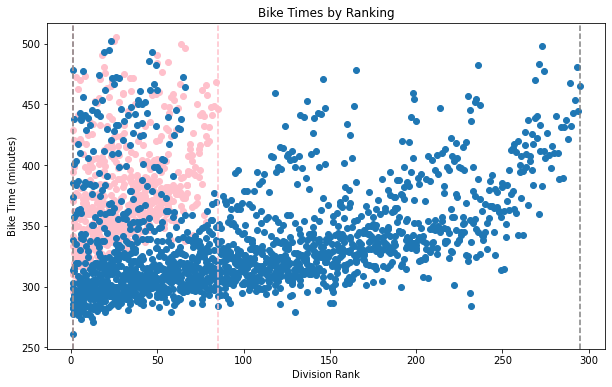

In [54]:
plot_genders_rank('Bike', df1=fem_agegroups, df2=male_agegroups)

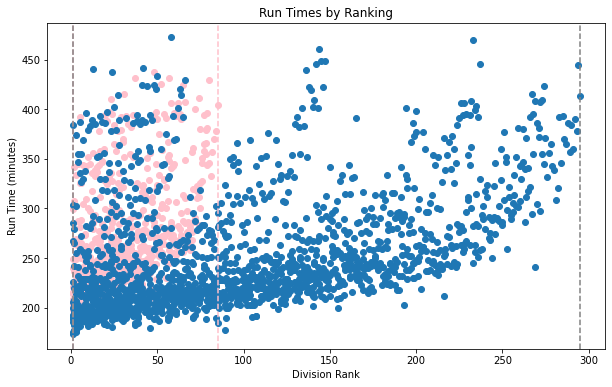

In [55]:
plot_genders_rank('Run', df1=fem_agegroups, df2=male_agegroups)

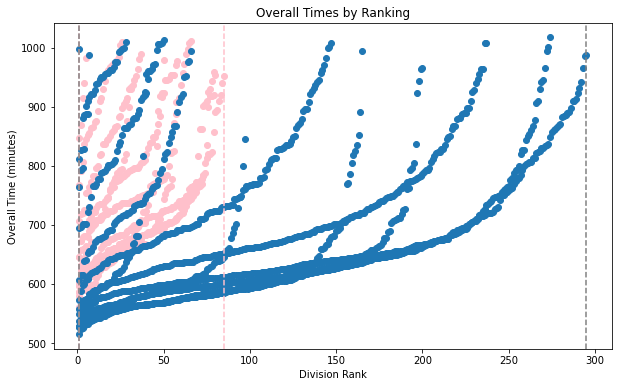

In [56]:
plot_genders_rank('Overall', df1=fem_agegroups, df2=male_agegroups)

# Do men race faster on average than women?

Based on these scatter plots, it certainly seems so. I will conduct a two-sample, unpaired T-Test since both gender's event times are independent of each other. This test states a null hypothesis and alternative hypothesis as follows:

Null hypothesis: men and women mean overall times are equal.

Alternative hypothesis: men and women mean overal times are not equal, or one of them races faster on average than the other.

In [ ]:
from scipy.stats import ttest_ind

In [33]:
t_statistic, pvalue = ttest_ind(male_pro['Overall'], fem_pro['Overall'], equal_var=False)
print(f'Pro t-test statistic: {round(t_statistic,2)}')
print(f'Pro p-value: {pvalue}')

Pro t-test statistic: -7.76
Pro p-value: 5.156855215220441e-10


The large, negative T-Test Statistic value (-7.76) means there is a very big difference between the gender's mean overall times. The very small P-value allows us to reject the null hypothesis in favor of the alternative hypothesis. Therefore we can reason that pro male triathletes, on average, race faster than pro women triathletes. We can run a similar test on the amateur gender groups:

In [36]:
t_statistic, pvalue = ttest_ind(male_agegroups['Overall'], fem_agegroups['Overall'], equal_var=False)
print(f'Amateur t-test statistic: {round(t_statistic,2)}')
print(f'Amateur p-value: {pvalue}')

Amateur t-test statistic: -13.63
Amateur p-value: 3.889330523969423e-39


The amateur gender race times give us stronger reason to reject the null hypothesis and state that on average, male amateur triathletes compete faster than female amateur triathletes.

# What correlation do event times have with ranking?

In [22]:
import seaborn as sns

## Normalizing data

In [23]:
df['Bool_Gender'] = df['Gender'] == "Female" # If you're female, Division Rank goes down
df['Bool_Gender'].astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
2253    1
2254    0
2255    1
2256    0
2257    0
Name: Bool_Gender, Length: 2256, dtype: int64

In [24]:
heatmap_cols = ['Swim', 'T1', 'Bike', 'T2', 'Run', 'Overall', 'Bool_Gender', 'Division Rank']

In [25]:
heat_df = df[heatmap_cols]

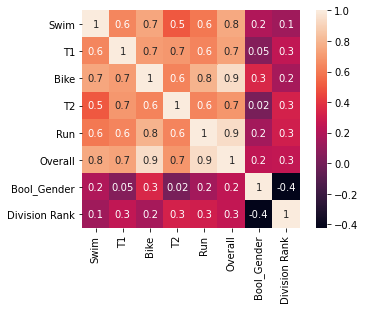

In [75]:
sns.heatmap(heat_df.corr(), annot = True, fmt='.1g', square=True)

Based on the correlation map, we can see that all three events: Swim, Bike, & Run have high correlations with the Overall Time but Swim is slightly less correlated than the other two sports. Run has the greatest correlation of the three events with division rank. Transition times, T1 and T2 have very high correlations with Division Rank! 

I'd like to take a look at just the pros.

<ipython-input-76-3a97ad3eade1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_pros['Bool_Gender'] = (df['Division'] == "FPRO")


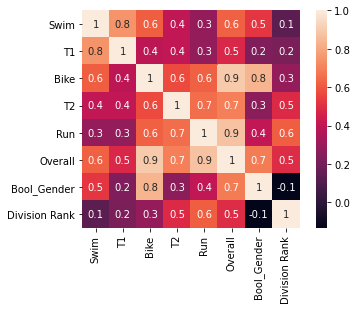

In [76]:
pro_mask = (df['Division'] == 'MPRO') | (df['Division'] == 'FPRO')
heat_pros = df[pro_mask]
heat_pros['Bool_Gender'] = (df['Division'] == "FPRO")
heat_pros['Bool_Gender'].astype(int)
plot = heat_pros[heatmap_cols]
sns.heatmap(plot.corr(), annot = True, fmt='.1g', square=True)

Swim has a much lower correlation in the pro division where Bike and Run times are highly correlated with Overall finish times. I think this has to do with the total distance of the event, 226.31km, and how that's divided amongst the three sports. Swim accounts for 1.7% of the entire race, Bike 79.6%, and Run is 18.7%. Meaning Bike and Run times dominate the Overall time.

Even more interesting is the correlation amongst event times and division rank: T2 and run times have the greatest correlations of all the event times with how pros rank.

Some questions that come up from this heatmap:

Why Run has the greatest correlation (0.6) of the three sports with Division Rank?

What relationship does Gender have with the sports?

-----> *Clean this up*

Assume that pro triathletes competing in Kona are i.i.d. samples of all possible pro triathletes. Computing statistics of this random sample: the sample mean. Since n > 30, Law of Large Numbers is valid and we can assume the distribution of sample means will be approximately normally distributed.

I would like to use the Maximum Likelihood Estimation to find the variance of each sample: Swim, Bike, and Run given the sample means generated by their data.

Steps:
1. Clean data further: Booleans for Gender
2. Isolate np.arrays of each category
3. Scatterplot each!
4. Calculate means for each category
5. Randomly sample from arrays of each category to generate np.arrays of means

Hyp Test: Does a slow or fast Swim time lead to a better Division Rank?

# How many amateurs are racing like pros?

I'm looking to bootstrap the lower 90th percentile of pro event times, and compare those to the bootstrapped 10th percentile of amateur event times.

i.e. if you race x or faster => pro

In [28]:
def times(df, sport):
    '''
    Returns an array of randomly chosen times according to the sport specified.
    
    Parameters:
    df: dataFrame pulling from
    sport: string: 'Swim', 'Bike', 'Run', or 'Overall'
    
    Returns:
    np.array of length 2434, with time entries in seconds
    '''
    l = df[sport]
    return np.random.choice(df[sport], size=len(l), replace=True)

In [29]:
def bootstrap_statistic(df, sport, samples, statistic):
    '''
    Returns an array of bootstrapped statistics
    
    Parameters:
    df: dataFrame pulling from
    sport: string: 'Swim', 'Bike', 'Run', or 'Overall'
    samples: int: # of samples desired
    statistic: string: statistic to calculate on sample i.e. np.median, np.var, np.std
    '''
    statistics = []
    for i in range(samples):
            samp = times(df, sport)
            statistics.append(statistic(samp))
    return statistics

In [30]:
def bootstrap_percentile(df, sport, samples, percent, statistic=np.percentile):
    '''
    Returns an array of bootstrapped percentiles
    
    Parameters:
    df: dataFrame pulling from
    sport: string: 'Swim', 'Bike', 'Run', or 'Overall'
    samples: int: # of samples desired
    statistic: np.percentile
    '''
    statistics = []
    for i in range(samples):
        samp = times(df, sport)
        statistics.append(statistic(samp, percent))
    return statistics

# Let's look at the "slower" pros:

In [31]:
def plot_pro_90(sport, df1=fem_pro, df2=male_pro):
    # Generate bootstrap 90th percentiles
    fem_90p = bootstrap_percentile(df1, sport, 1000, 90)
    male_90p = bootstrap_percentile(df2, sport, 1000, 90)
    
    # Say it with confidence
    left_f90p = np.percentile(fem_90p, 2.5)
    right_f90p = np.percentile(fem_90p, 97.5)

    left_m90p = np.percentile(male_90p, 2.5)
    right_m90p = np.percentile(male_90p, 97.5)
    
    # Plot it
    fig, ax = plt.subplots(1, figsize=(12,4))
    ax.hist(fem_90p, bins=50, density=True, color='pink', alpha=0.8, label=f'Female Pro {sport} 90th Percentile')
    ax.hist(male_90p, bins=50, density=True, color='b', alpha=0.7, label=f'Male Pro {sport} 90th Percentile')
    ax.legend()

    ax.set_title(f'Pro {sport} 90th Percentiles', fontsize=20)
    ax.set_xlabel(f'{sport} Time (seconds)', fontsize=15)

    ax.axvline(left_f90p, c='pink', linestyle="--")
    ax.axvline(right_f90p, c='pink', linestyle="--")
    ax.axvline(left_m90p, c='grey', linestyle="--")
    ax.axvline(right_m90p, c='grey', linestyle="--")
    
    print(f'Female Pro {sport} Times Bootstrap Confidence Interval for Population 90th Percentile (seconds): [{round(left_f90p, 2)}, {round(right_f90p,2)}]')
    print(f'Male Pro {sport} Times Bootstrap Confidence Interval for Population 90th Percentile (seconds): [{round(left_m90p, 2)}, {round(right_m90p,2)}]')

    return fig, ax

Female Pro Swim Times Bootstrap Confidence Interval for Population 90th Percentile (seconds): [3766.0, 4524.0]
Male Pro Swim Times Bootstrap Confidence Interval for Population 90th Percentile (seconds): [3143.0, 3470.0]


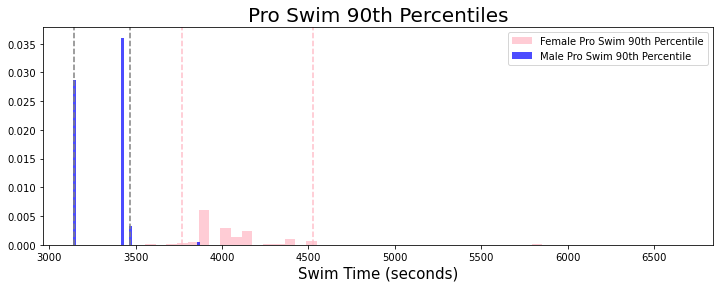

In [77]:
plot_pro_90('Swim')

In effort to answer the question, how fast do you need to swim to be considered a pro? We can see our 95% confidence interval for the 10th percentile of Female and Male Pro swim times. Therefore, if you swim in, or faster than this 10th percentile, I am 95% confident you are considered a pro swimming triathlete!

Female Pro Bike Times Bootstrap Confidence Interval for Population 90th Percentile (seconds): [18524.0, 19995.0]
Male Pro Bike Times Bootstrap Confidence Interval for Population 90th Percentile (seconds): [16437.0, 16990.0]


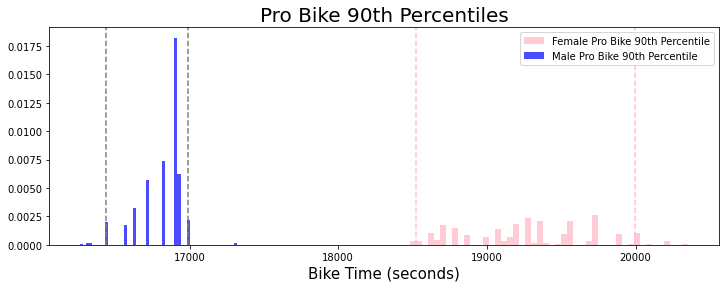

In [78]:
plot_pro_90('Bike')

Female Pro Run Times Bootstrap Confidence Interval for Population 90th Percentile (seconds): [12822.88, 17856.0]
Male Pro Run Times Bootstrap Confidence Interval for Population 90th Percentile (seconds): [11597.0, 13282.0]


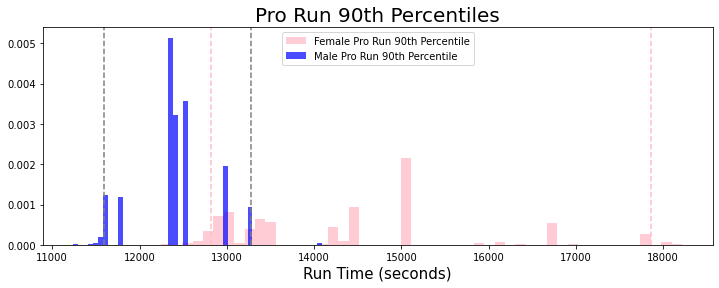

In [79]:
plot_pro_90('Run')

Something to keep in mind is that to be considered pro, you would need to compete in this percentile range (or faster) and have done all triathlon activities in the same order: swim-bike-run.

Female Pro Overall Times Bootstrap Confidence Interval for Population 90th Percentile (seconds): [35186.5, 41302.0]
Male Pro Overall Times Bootstrap Confidence Interval for Population 90th Percentile (seconds): [31279.0, 32934.0]


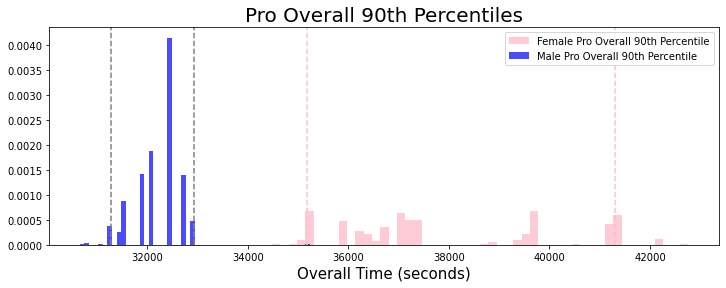

In [80]:
plot_pro_90('Overall')

# Let's look at the amateur times with the pro times 95% confidence intervals

In [36]:
def plot_amateur_proci(sport, df1=fem_agegroups, df2=male_agegroups, df3=fem_pro, df4=male_pro):
    # Convert Amateur times to minutes
    f_agegroups_ = df1[sport] / 60
    m_agegroups_ = df2[sport] / 60

    # Generate pro bootstrap 90th percentiles
    fem_90p = bootstrap_percentile(df3, sport, 1000, 90)
    male_90p = bootstrap_percentile(df4, sport, 1000, 90)
    
    # Say it with confidence
    left_f90p = np.percentile(fem_90p, 2.5) / 60
    right_f90p = np.percentile(fem_90p, 97.5) / 60

    left_m90p = np.percentile(male_90p, 2.5) / 60
    right_m90p = np.percentile(male_90p, 97.5) /60
    
    # Plot it
    fig, ax = plt.subplots(1, figsize=(12,4))
    
    ax.hist(m_agegroups_, bins=100, density=True, color='grey', alpha=0.75, label=f'Male Amateur {sport} Times')
    ax.hist(f_agegroups_, bins=100, density=True, color='pink', alpha=0.75, label=f'Female Amateur {sport} Times')
    ax.axvline(left_f90p, c='red', linestyle="--", label='Female Pro 90 Percentile')
    ax.axvline(right_f90p, c='red', linestyle="--")
    ax.axvline(left_m90p, c='black', linestyle="--", label='Male Pro 90 Percentile')
    ax.axvline(right_m90p, c='black', linestyle="--")
    ax.legend()

    ax.set_title(f'How do Amateurs Compare to the Pro {sport} 90th Percentile?', fontsize=20)
    ax.set_xlabel(f'{sport} Time (minutes)', fontsize=15)
    
    m_ = m_agegroups_[m_agegroups_ <= right_m90p]
    f_ = f_agegroups_[f_agegroups_ <= right_f90p]
    mam_pros_ = round((len(m_) / len(m_agegroups_))*100, 2)
    fam_pros_ = round((len(f_) / len(f_agegroups_))*100, 2)
    print(f'Percent of male amateurs who {sport} like pros: {mam_pros_}%')
    print(f'Percent of female amateurs who {sport} like pros: {fam_pros_}%')

    return fig, ax

Percent of male amateurs who Swim like pros: 8.28%
Percent of female amateurs who Swim like pros: 48.52%


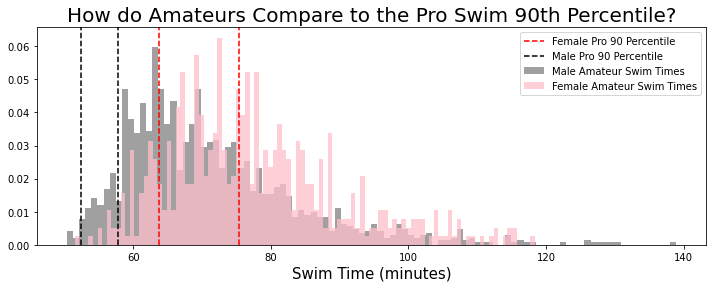

In [81]:
plot_amateur_proci('Swim')

Percent of male amateurs who Bike like pros: 1.74%
Percent of female amateurs who Bike like pros: 11.69%


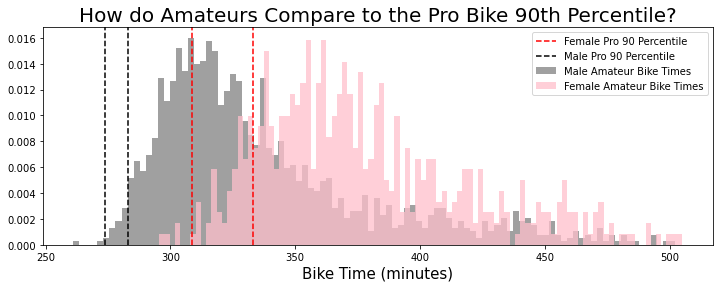

In [82]:
plot_amateur_proci('Bike')

Percent of male amateurs who Run like pros: 37.09%
Percent of female amateurs who Run like pros: 72.43%


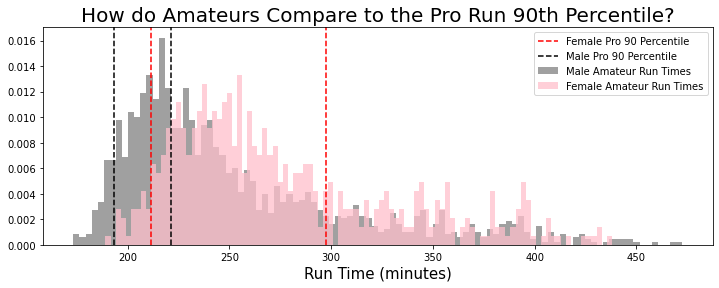

In [83]:
plot_amateur_proci('Run')

We can see from our original female pro run times, that 3-4 female pro runners were much slower than the majority of the female pro runners, bringing their 90th percentile further right. Which is why the percent of female amateurs who run like these pros is so high.

Percent of male amateurs who Overall like pros: 2.74%
Percent of female amateurs who Overall like pros: 36.47%


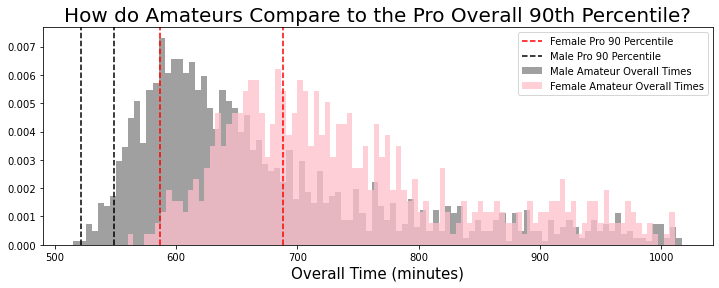

In [84]:
plot_amateur_proci('Overall')

# Better: Bootstrap 10th percentile of amateur times and compare to pro's 90th percentile

In [41]:
'''
scrap
    
    m_ = male_10[male_10 <= right_m90]
    f_ = fem_10[fem_10 <= right_f90]
    mam_pros_ = round((len(m_) / len(male_10))*100, 2)
    fam_pros_ = round((len(f_) / len(fem_10))*100, 2)
    print(f'Percent of male 10 percentile amateurs who {sport} like 90 percentile pros: {mam_pros_}%')
    print(f'Percent of female 10 percentile amateurs who {sport} like 90 percentile pros: {fam_pros_}%')
'''

"\nscrap\n    \n    m_ = male_10[male_10 <= right_m90]\n    f_ = fem_10[fem_10 <= right_f90]\n    mam_pros_ = round((len(m_) / len(male_10))*100, 2)\n    fam_pros_ = round((len(f_) / len(fem_10))*100, 2)\n    print(f'Percent of male 10 percentile amateurs who {sport} like 90 percentile pros: {mam_pros_}%')\n    print(f'Percent of female 10 percentile amateurs who {sport} like 90 percentile pros: {fam_pros_}%')\n"

In [42]:
def plot_cis(sport, df1=fem_agegroups, df2=male_agegroups, df3=fem_pro, df4=male_pro):    
    # Bootstrap amateur 10th percentiles
    fem_10 = bootstrap_percentile(df1, sport, 1000, 10)
    male_10 = bootstrap_percentile(df2, sport, 1000, 10)
    
    # Say it with confidence
    left_f10 = np.percentile(fem_10, 2.5)
    right_f10 = np.percentile(fem_10, 97.5)
    left_m10 = np.percentile(male_10, 2.5)
    right_m10 = np.percentile(male_10, 97.5)
    
    # Generate pro bootstrap 90th percentiles
    fem_90 = bootstrap_percentile(df3, sport, 1000, 90)
    male_90 = bootstrap_percentile(df4, sport, 1000, 90)
    
    # Say it with confidence
    left_f90 = np.percentile(fem_90, 2.5)
    right_f90 = np.percentile(fem_90, 97.5)
    left_m90 = np.percentile(male_90, 2.5)
    right_m90 = np.percentile(male_90, 97.5)
    
    # Plot it
    fig, ax = plt.subplots(1, figsize=(12,4))
    
    ax.hist(male_10, bins=100, density=True, color='grey', alpha=0.75, label=f'Male Amateur {sport} 10 Percentiles')
    ax.hist(fem_10, bins=100, density=True, color='pink', alpha=0.75, label=f'Female Amateur {sport} 10 Percentiles')
    ax.axvline(left_f90, c='red', linestyle="--", label='Female Pro 90 Percentile')
    ax.axvline(right_f90, c='red', linestyle="--")
    ax.axvline(left_m90, c='black', linestyle="--", label='Male Pro 90 Percentile')
    ax.axvline(right_m90, c='black', linestyle="--")
    ax.legend()

    ax.set_title(f'How does the {sport} Amateur 10th Percentile Compare to the Pro 90th Percentile?', fontsize=20)
    ax.set_xlabel(f'{sport} Time (seconds)', fontsize=15)

    return fig, ax

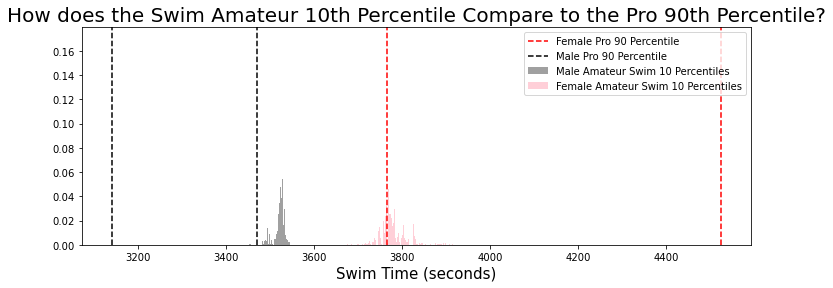

In [85]:
plot_cis('Swim')

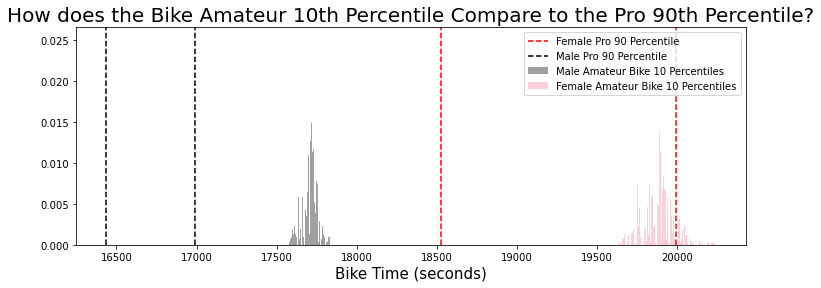

In [86]:
plot_cis('Bike')

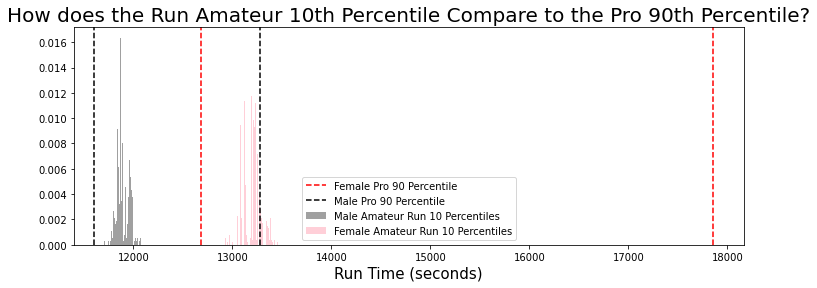

In [87]:
plot_cis('Run')

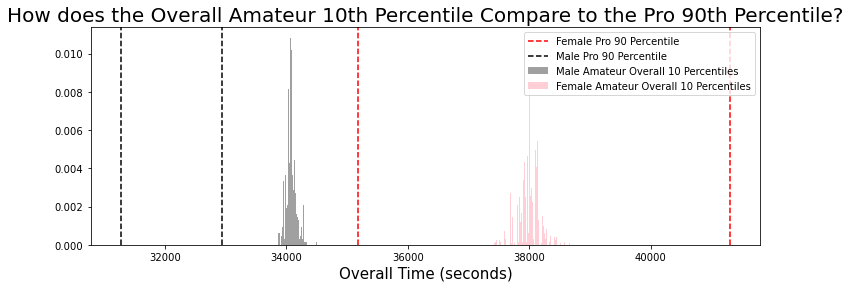

In [88]:
plot_cis('Overall')

This shows me I need to go back and clean out the female pro that is weighing down the values.

# Next compare event times to athlete's overall rank

To better see the event time's weight in their correlation with athlete's Overall Rank, I will standardize the timed event columns and plot them against Overall Rank!

Notes:

Athletes in 10 percentile Swim, also perform in 10 percentile Bike, or Run or Overall.
H0: 10% Swim => no better in Overall
    10% Swim - A
    90% Swim - B
Ha: 10% Swim == 10% other events

Standardized MA: standardization - subtract mean from ea. swim row, then divide by std dev
    Do this for all 'time' columns to be able to compare them
    This would change columns to non-dimensional

Bootstrap *mean* times 
Man Whitney U test: non-parametric version of the t-test

Adv.
Are countries surrounded by more water, producing athletes in 10% Swim?


In [47]:
# Standardize event time columns by subtracting mean and dividing by standard deviation:
df['Norm_Swim'] = ( df['Swim'] - np.mean(df['Swim']) ) / np.std(df['Swim'])
df['Norm_Bike'] = ( df['Bike'] - np.mean(df['Bike']) ) / np.std(df['Bike'])
df['Norm_Run'] = ( df['Run'] - np.mean(df['Run']) ) / np.std(df['Run'])
df['Norm_T1'] = ( df['T1'] - np.mean(df['T1']) ) / np.std(df['T1'])
df['Norm_T2'] = ( df['T2'] - np.mean(df['T2']) ) / np.std(df['T2'])

In [49]:
def rankvsevent(col1, normalized_sport):
    '''
    Plots athlete's Overall Rank vs. sport time in a bar plot
    '''
    fig, ax = plt.subplots(1, figsize=(12,4))
    
    ax.bar(col1, df[normalized_sport])
    ax.set_title(f'Overall Rank vs. {normalized_sport} Times', fontsize=20)
    ax.set_xlabel(f'Overall Rank', fontsize=15)
    ax.set_ylabel(f'Non Dimensional {normalized_sport} Time')
    return fig, ax

(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07d9fac9d0>)

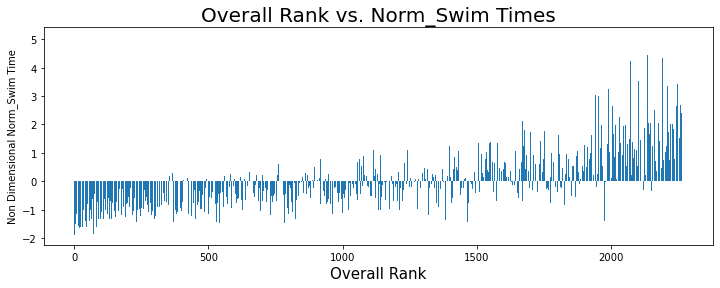

In [56]:
rankvsevent(df['Overall Rank'], 'Norm_Swim')

(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07d9facfa0>)

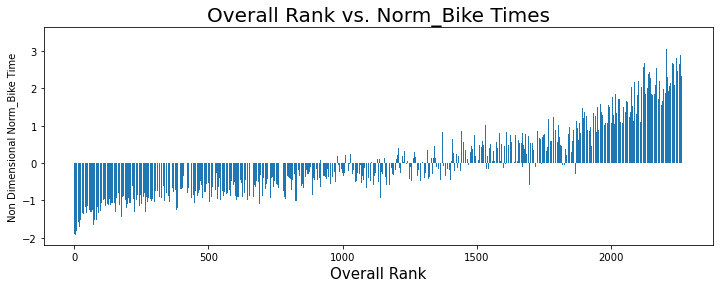

In [57]:
rankvsevent(df['Overall Rank'], 'Norm_Bike')

(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07d7a73a30>)

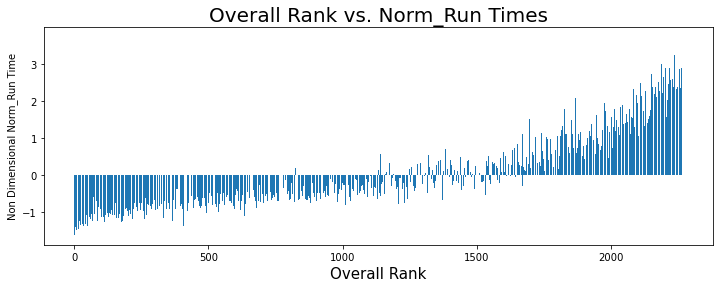

In [58]:
rankvsevent(df['Overall Rank'], 'Norm_Run')

(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07d5ba2400>)

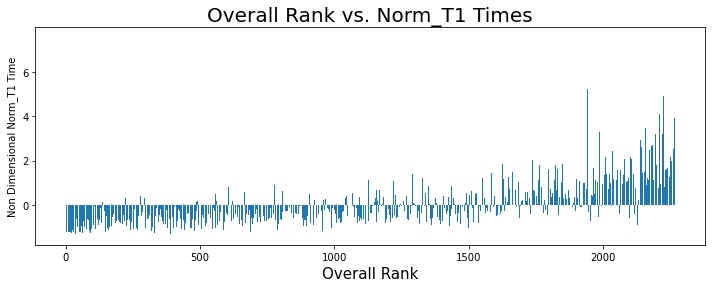

In [59]:
rankvsevent(df['Overall Rank'], 'Norm_T1')

(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07d447c6d0>)

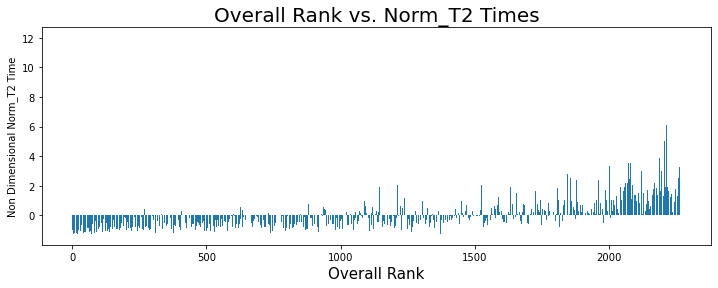

In [60]:
rankvsevent(df['Overall Rank'], 'Norm_T2')

# Do athletes who perform consistent in event times perform better than inconsistent athletes?

In [ ]:
# another q: which event falls off faster w/age

# consistency metric: each athlete, max norm - min norm
# => consistency in that event
# sum "consistencies" compared to Overall Rank, Division, Division Rank, etc.

In [50]:
def consistency(row):
    '''
    Returns difference from standardized mean
    '''
    return max(row.Norm_Swim, row.Norm_Run, row.Norm_Bike) - min(row.Norm_Swim, row.Norm_Run, row.Norm_Bike)

In [51]:
df['Consistency'] = df.apply(consistency, axis=1)

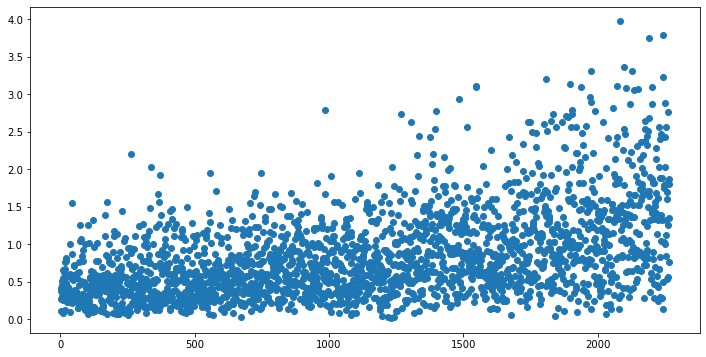

In [52]:
fig, ax = plt.subplots(1, figsize=(12,6))

ax.scatter('Overall Rank', 'Consistency', data=df)

In [53]:
df

,Name,Country,Gender,Division,Swim,Bike,Run,Overall,Division Rank,Gender Rank,Overall Rank,T1,T2,Bool_Gender,Norm_Swim,Norm_Bike,Norm_Run,Norm_T1,Norm_T2,Consistency
0,"Frodeno, Jan",DEU,Male,MPRO,2851.0,15362.0,9763.0,28273.0,1,1,1,118.0,179.0,False,-1.883184,-1.893678,-1.626397,-1.332243,-1.008652,0.267281
1,"O'donnell, Tim",USA,Male,MPRO,2858.0,15491.0,10185.0,28781.0,2,2,2,121.0,126.0,False,-1.874301,-1.848245,-1.504890,-1.309350,-1.315450,0.369411
2,"Kienle, Sebastian",DEU,Male,MPRO,3137.0,15304.0,10196.0,28924.0,3,3,3,132.0,155.0,False,-1.520258,-1.914105,-1.501723,-1.225408,-1.147579,0.412382
3,"Hoffman, Ben",USA,Male,MPRO,3061.0,15841.0,9788.0,28972.0,4,4,4,145.0,137.0,False,-1.616700,-1.724977,-1.619199,-1.126203,-1.251775,0.108277
4,"Wurf, Cameron",AUS,Male,MPRO,3145.0,15284.0,10503.0,29201.0,5,5,5,127.0,142.0,False,-1.510107,-1.921149,-1.413328,-1.263563,-1.222832,0.507820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2253,"Beavers, Cathy",USA,Female,F65-69,6330.0,30301.0,22732.0,60603.0,26,609,2262,625.0,615.0,True,2.531568,3.367750,2.107774,2.536726,1.515199,1.259976
2254,"Whitehouse, Paul",USA,Male,M70-74,7561.0,28280.0,23374.0,60604.0,28,1654,2263,709.0,680.0,False,4.093672,2.655966,2.292626,3.177738,1.891462,1.801046
2255,"Svoboda-vasquez, Hanna",DEU,Female,F50-54,5373.0,29787.0,24462.0,60663.0,66,610,2264,587.0,454.0,True,1.317162,3.186722,2.605894,2.246744,0.583227,1.869560
2256,"Piasentini, Edgardo",ARG,Male,M65-69,6147.0,27729.0,26029.0,60801.0,50,1655,2265,377.0,519.0,False,2.299346,2.461907,3.057081,0.644213,0.959489,0.757735


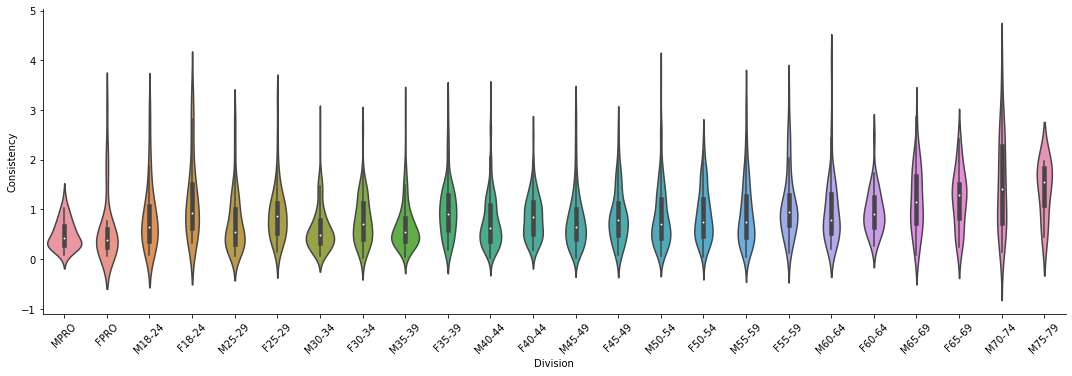

In [61]:
ax = sns.catplot(x='Division', y='Consistency',  kind='violin', split=True, data=df, 
                 order=['MPRO', 'FPRO', 'M18-24', 'F18-24', 'M25-29', 'F25-29', 'M30-34', 'F30-34', 'M35-39', 'F35-39', 'M40-44', 'F40-44',
                       'M45-49', 'F45-49', 'M50-54', 'F50-54', 'M55-59', 'F55-59', 'M60-64', 'F60-64', 'M65-69', 'F65-69', 'M70-74', 'M75-79'], height=5, aspect=3);
ax.set_xticklabels(rotation=45)

In [ ]:
new_df = df[['Bool_Gender', 'Norm_Swim', 'Norm_Bike', 'Norm_Run', 'Norm_T1', 'Norm_T2','Division', 'Division Rank', 'Overall Rank', 'Consistency']]
new_df

In [ ]:
sns.pairplot(new_df, hue="Bool_Gender", palette="husl")